In [8]:
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from skimage import measure
import rfp_functions as rf 

rfp_functions is a file that includes useful functions for identifying the reversed flux patches

In [9]:
r=3480                                     # radius of CMB
theta=np.arange(0.45,180,0.45)             # longitude grid points
phi=np.arange(0.,360,0.45)                 # colatitude grid points
lat_w=np.around(theta[1]-theta[0],3)
lon_w=np.around(phi[1]-phi[0],3)
[phim,thetam]=np.meshgrid(phi,theta)

##load Br data
path_me = r'Br\cov_obsx1\grid=0.45\L=3'     
path_f = r'Br\cov_obsx1\grid=0.45\L=14'
flist_me = os.listdir(os.getcwd()+'\\'+path_me)              
flist_f = os.listdir(os.getcwd()+'\\'+path_f)

First we need to load Br (radial magnetic field ) data which can be calculated from Gauss coefficients. Note that the Br should be calculated by the same grid space with theta, phi here. Here two Br data is loaded, one is for identifying the magnetic equator and another is for identifying the reversed flux patches. 

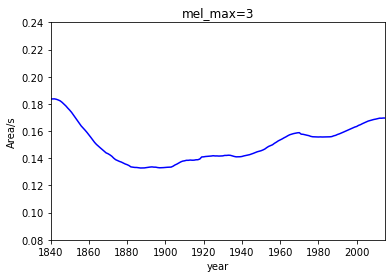

In [10]:
#example 1   calculate the rate of the reversed area over the whole CMB 
f_year = []
f_area_e = []
f_area_r = []
for fp in flist_me:
    Br_me = np.load(path_me+'\\'+fp)
    Br_f = np.load(path_f+'\\'+fp)
    [mequt_lat,mequt_lon]=rf.idf_mequt(Br_me,phi,theta)    # find the magnetic equator
    [rfp_lon,rfp_lat,e_lon,e_lat]=rf.idf_rfp(mequt_lon,mequt_lat,Br_f,phi,theta) # find the rfp
    
    area_r=rf.get_area2rfp(rfp_lat,lat_w,lon_w,r)
    area_e=rf.get_area2rfp(e_lat,lat_w,lon_w,r)       
    f_area_r=np.append(f_area_r,area_r)
    f_area_e=np.append(f_area_e,area_e)
    f_year=np.append(f_year,float(fp[0:-4]))
s_rate=(f_area_r-f_area_e)/(4*np.pi*r*r)

ify=np.argsort(f_year)
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
plot1=ax.plot(f_year[ify],s_rate[ify],color='b')
ax.set_xlim(1840,2015)
ax.set_ylim(0.08,0.24)
ax.set_title('mel_max=3')            
ax.set_xlabel('year')
ax.set_ylabel('Area/s') 
plt.show()

Example 1 calculates the rate of reversed flux patches area over the whole spherical surface of CMB, using the COV-OBS.x1 mean model with $l_{max}^{eq}=3$. This result is similar with the Fig. 3(b) of M.C.Metman, 2018.

C:\Users\xukai\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


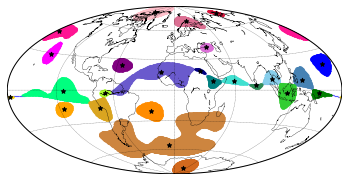

In [11]:
# example 2 identify and label the patches

# transform Br to binary matrix
bw = rf.bw_rfp(mequt_lon,mequt_lat,Br_f,phi,theta)
# label the patch
label_bw = measure.label(bw,connectivity=1)
label_bw = rf.merge_edge_label(label_bw)    


colo_sed=np.array(['pink','crimson','palevioletred','deeppink','orchid','fuchsia','purple','slateblue','blue','navy','steelblue','skyblue','cadetblue','cyan','teal','turquoise','springgreen','seagreen','limegreen','green','greenyellow','olivedrab','yellow','olive','gold','goldenrod','orange','darkorange','peru','chocolate','sienna','coral','orangered','red','firebrick','maroon'])
coloM=np.append(colo_sed,colo_sed)

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
map=Basemap(projection='hammer',lon_0=0,resolution='c')
map.drawcoastlines(linewidth=0.3)
map.drawparallels(np.arange(-60,90,30),labels=[0,0,0,0],linewidth=0.3)
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,0],linewidth=0.3)
map.scatter(mequt_lon,90-mequt_lat,s=0.01,color='b',latlon=True)
for klass, cr in zip(range(1, max(label_bw.flatten())+1), coloM):
    phit = phim[label_bw == klass]
    thetat = thetam[label_bw == klass]
    #filter the error patches
    if len(phit) < 10:
        continue
    # calculate the mass center of the patch
    Bt = np.around(Br_f[label_bw == klass],5)
    w=abs(Bt)
    [Xt,Yt,Zt]=rf.rtp2xyz(r, thetat, phit)
    x_mass = np.sum(Xt*w)/np.sum(w)
    y_mass = np.sum(Yt*w)/np.sum(w)
    z_mass = np.sum(Zt*w)/np.sum(w)
    [theta_mass,phi_mass] = rf.xyz2rtp(x_mass, y_mass, z_mass)
    # plot 
    map.scatter(phit.T, 90-thetat.T,color=cr,s=1,latlon=True)
    map.scatter(phi_mass,90-theta_mass,color='k',s=20,marker='*',latlon=True)

Here a binary segmentation method is used to split and label every patches.  Since Br is calculated from 0~360 degree longitude, it is discontinued at prime meridian and the patches crossed by the prime meridian are identified two different patches. merge_edge_label is used to fix this problem

This binary segmentation method is very sensitive at the connection of two patches that it may identify some isolated points as a new patch. So here
    if len(phit) < 10:
        continue
is used to filter this illusory patches. If this filter is deleted, small illusory patches appear:

C:\Users\xukai\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


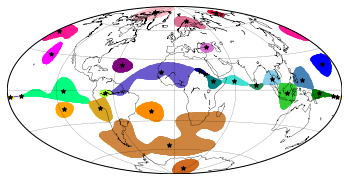

In [12]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
map=Basemap(projection='hammer',lon_0=0,resolution='c')
map.drawcoastlines(linewidth=0.3)
map.drawparallels(np.arange(-60,90,30),labels=[0,0,0,0],linewidth=0.3)
map.drawmeridians(np.arange(-180,180,60),labels=[0,0,0,0],linewidth=0.3)
map.scatter(mequt_lon,90-mequt_lat,s=0.01,color='b',latlon=True)
for klass, cr in zip(range(1, max(label_bw.flatten())+1), coloM):
    phit = phim[label_bw == klass]
    thetat = thetam[label_bw == klass]
    # calculate the mass center of the patch
    Bt = np.around(Br_f[label_bw == klass],5)
    w=abs(Bt)
    [Xt,Yt,Zt]=rf.rtp2xyz(r, thetat, phit)
    x_mass = np.sum(Xt*w)/np.sum(w)
    y_mass = np.sum(Yt*w)/np.sum(w)
    z_mass = np.sum(Zt*w)/np.sum(w)
    [theta_mass,phi_mass] = rf.xyz2rtp(x_mass, y_mass, z_mass)
    # plot 
    map.scatter(phit.T, 90-thetat.T,color=cr,s=1,latlon=True)
    map.scatter(phi_mass,90-theta_mass,color='k',s=20,marker='*',latlon=True)